#### The CNN32 model

The bigger model will be used later as a teacher model. The model must have a real good accuracy on validation data.

In [1]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 400                      # earlystopping, see model.fit
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 32
use_grayscale = False                # grayscale or rgb
model_filename = "cnn32"

##########################################################################

from sklearn.model_selection import train_test_split
from b2n.data.tmnist import tmnist_percentals
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import *
from sklearn.utils import shuffle
from b2n.encodings.class_encoding import *
from b2n.augmentation.generator import *

#### 

## Load data

Like the distillation network meter digits will be trained with font builded images.

### digit meter images

The meter digits are all 0-9 ziffer_raw (https://github.com/jomjol/neural-network-autotrain-digital-counter/tree/main/ziffer_raw) and other collected data (used https://github.com/haverland/collectmeterdigits).


### Percental TMNIST

300.000 images of type face fonts in 0.1 steps from 0.0 to 9.9

See https://www.kaggle.com/datasets/frankhaverland/percentile-tmnist-for-electric-meters


### Train and Test data

For 1st train both dataset mixed are used.

### digit meter spread

The percental TMNIST has for every label the same count of data.

The images of digit meters are collected and labeled by hand. So the image count of labels are differnt. The meter digit spread plot shows the count for each label.

Ziffer data count:  12478
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-13 09:47:36.005560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-13 09:47:36.005722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(224129, 32, 20, 3)
dataset x_train-size=224129


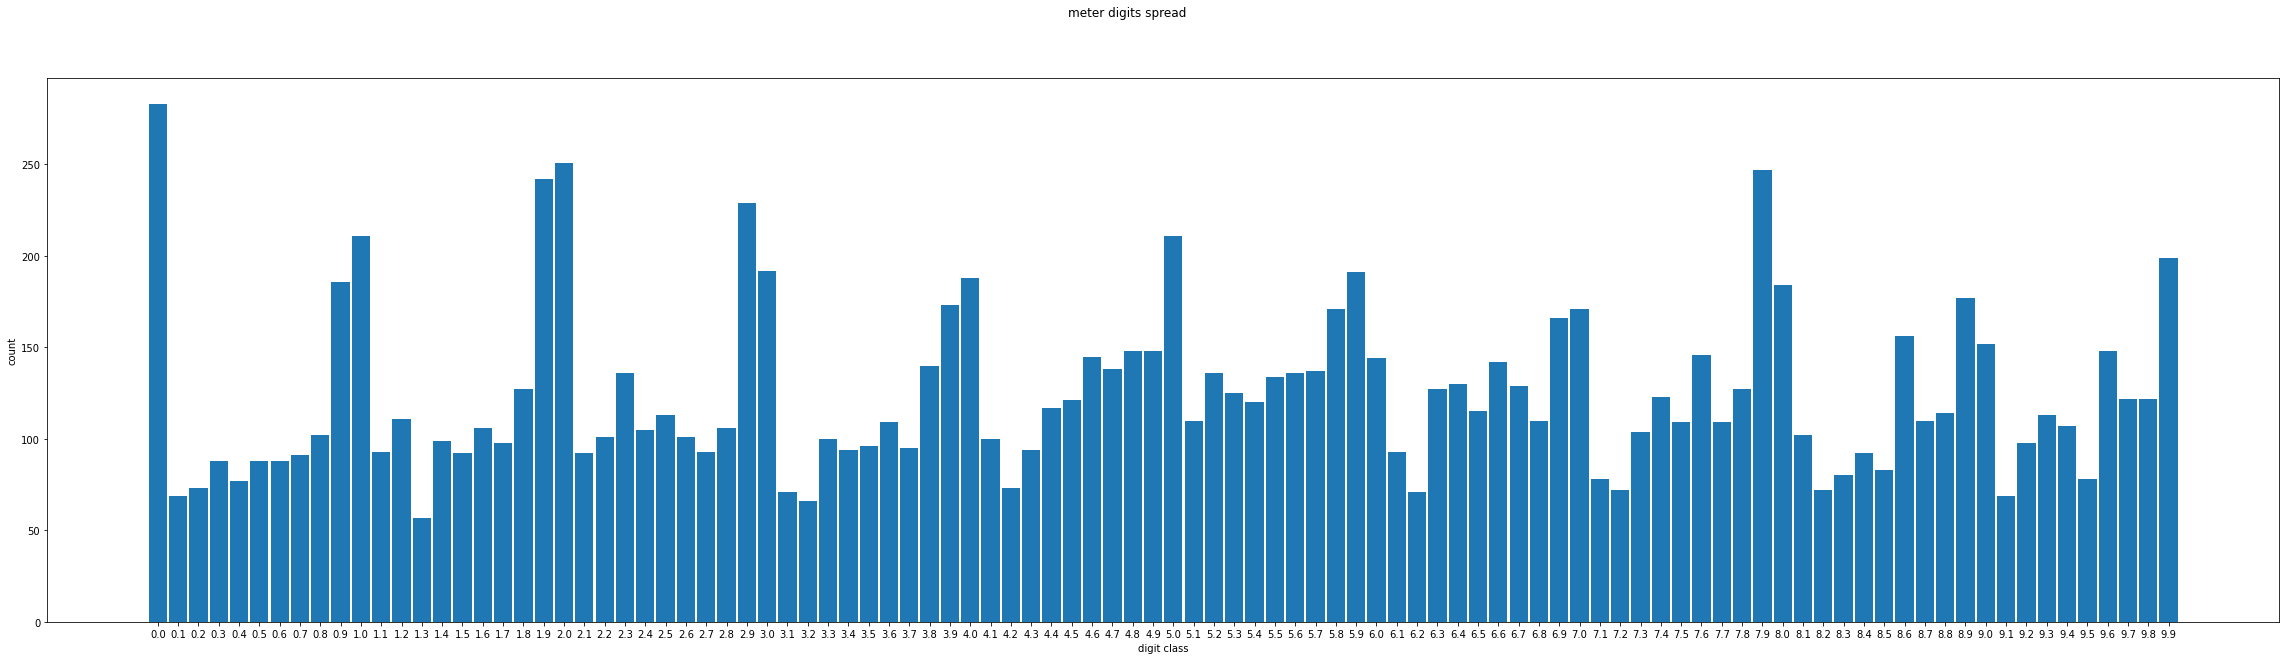

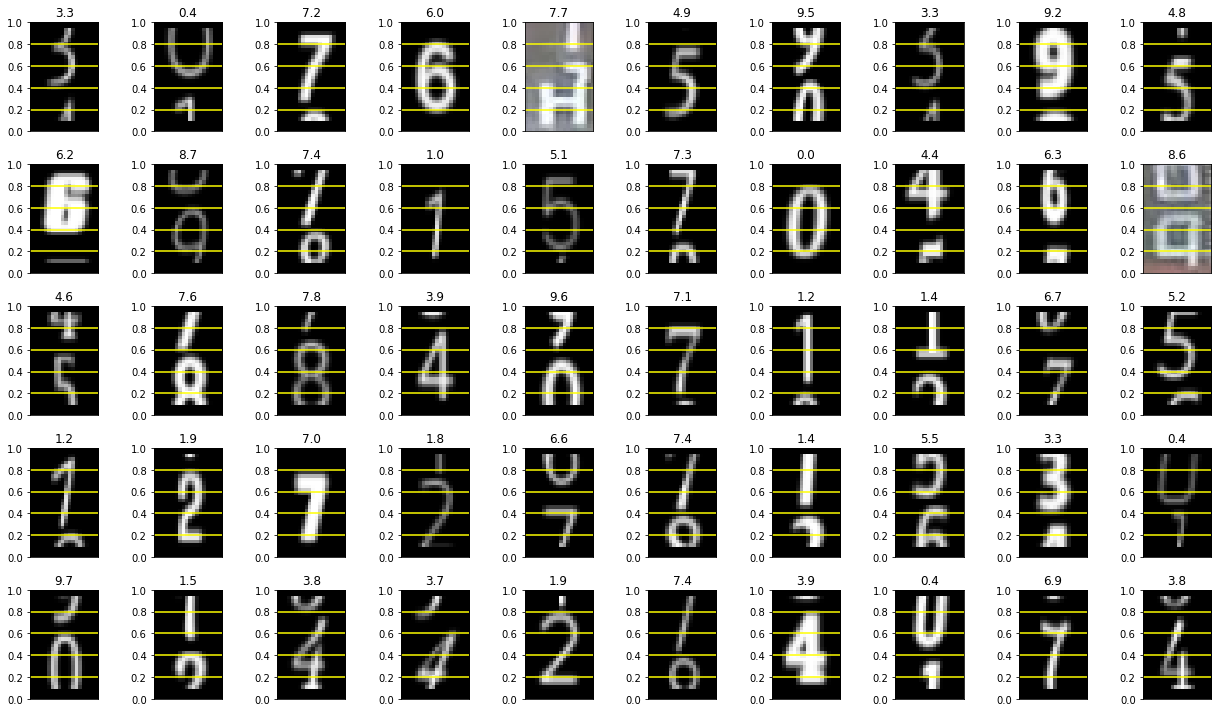

In [2]:
from sklearn.model_selection import train_test_split

xz_data, yz_data, fz_data = ziffer_data(input_dir='images')

# distribution
_, inverse = np.unique(yz_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
plot_divergence(ziffer_bincount, "meter digits spread", nb_classes)


# Split train and validation data 
xz_train, yz_train = shuffle(xz_data, yz_data)
xz_train, xz_test, yz_train, yz_test = train_test_split(xz_train, yz_train, test_size=Training_Percentage)


xt_data, yt_data = tmnist_percentals()


x_data = np.concatenate((xt_data, xz_train))
y_data = np.concatenate((yt_data, yz_train))
x_data, y_data = shuffle(x_data, y_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)

print(x_train.shape)

input_shape=x_train[0].shape
print(f"dataset x_train-size={len(x_train)}")
plot_dataset(x_train, y_train)

y_train = class_encoding(y_train, nb_classes)
y_test = class_encoding(y_test, nb_classes)

yz_train = class_encoding(yz_train, nb_classes)
yz_test = class_encoding(yz_test, nb_classes)


### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting, spot light and noising images.

The validation set is not augmentated. It uses only meter digit images for a real result how the model fits to meter digits.
So the validation says more about the results and its easier to use a early stopping mechanism.

Train data


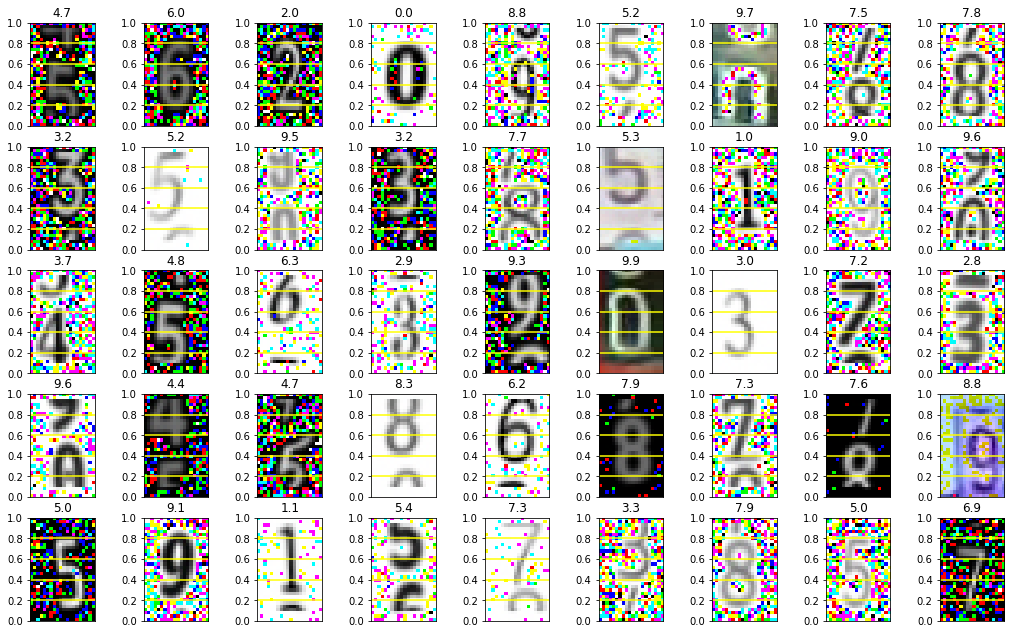

Validation data


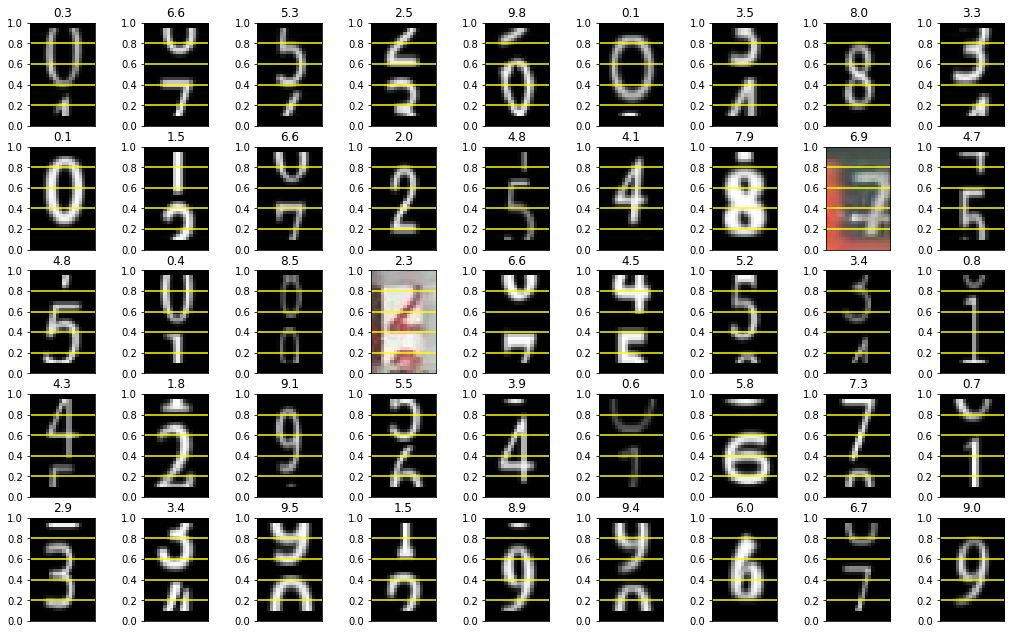

In [3]:
import numpy as np

train_iterator = augmentation(x_train, y_train, preprocessing_function=invert_noise)
validation_iterator = no_augmentation(x_test, y_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 


### The Model

Classic CNN model.

In [4]:
import tensorflow as tf
from b2n.models.cnn32 import VGG_like
model = VGG_like(input_shape, nb_classes)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

### The Training

Standard training of the model with complete dataset.

The ModelCheckpoint helps to keep the best model. 

Epoch 1/400


2022-06-13 09:48:02.405317: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-13 09:48:02.790573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7005/7005 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.7974

2022-06-13 09:50:01.336132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.97266, saving model to cnn32_best.h5
7005/7005 [==============================] - 131s 19ms/step - loss: 0.8523 - accuracy: 0.7974 - val_loss: 0.0900 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 2/400
7003/7005 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9662
Epoch 2: val_accuracy improved from 0.97266 to 0.97912, saving model to cnn32_best.h5
7005/7005 [==============================] - 129s 18ms/step - loss: 0.1210 - accuracy: 0.9662 - val_loss: 0.0677 - val_accuracy: 0.9791 - lr: 9.8000e-04
Epoch 3/400
7005/7005 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9738
Epoch 3: val_accuracy improved from 0.97912 to 0.98506, saving model to cnn32_best.h5
7005/7005 [==============================] - 130s 19ms/step - loss: 0.0922 - accuracy: 0.9738 - val_loss: 0.0473 - val_accuracy: 0.9851 - lr: 9.6040e-04
Epoch 4/400
7005/7005 [==============================] - ETA: 0s - loss: 0.0764 - accuracy:

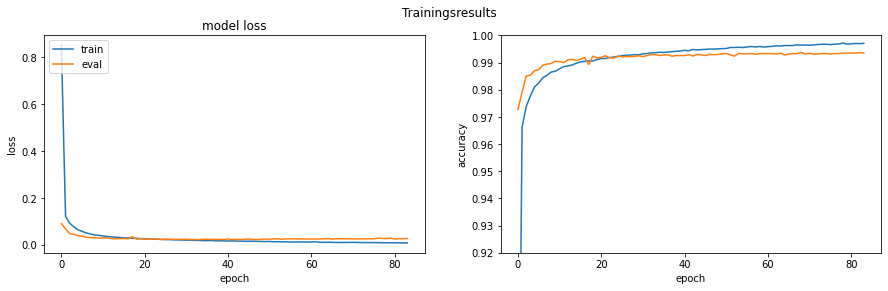

In [5]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x, verbose=0)
earlystop = EarlyStopping(monitor='val_loss', mode='min' , patience=50, verbose=1, baseline=0.04, restore_best_weights=True)
mc = ModelCheckpoint(model_filename + '_best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[annealer, earlystop, mc],
                verbose=1)

plot_acc_loss(history, "Trainingsresults")

### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation

2022-06-13 12:49:30.876975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Tested images: 12478. 69 false predicted. Accuracy is: 0.9944702676711011


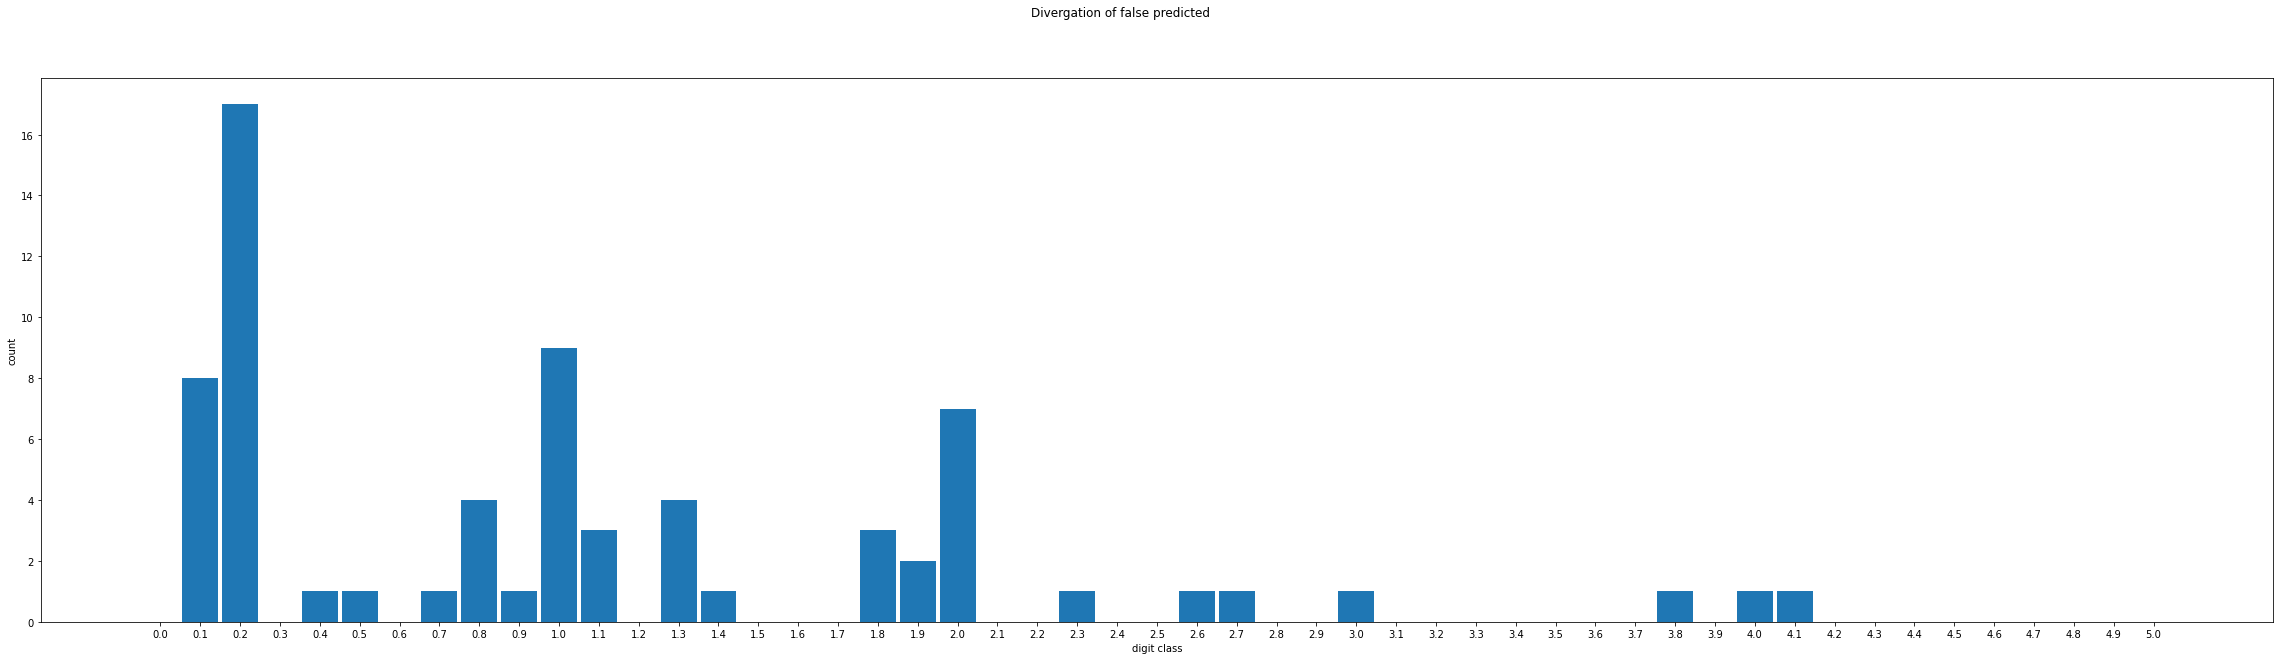

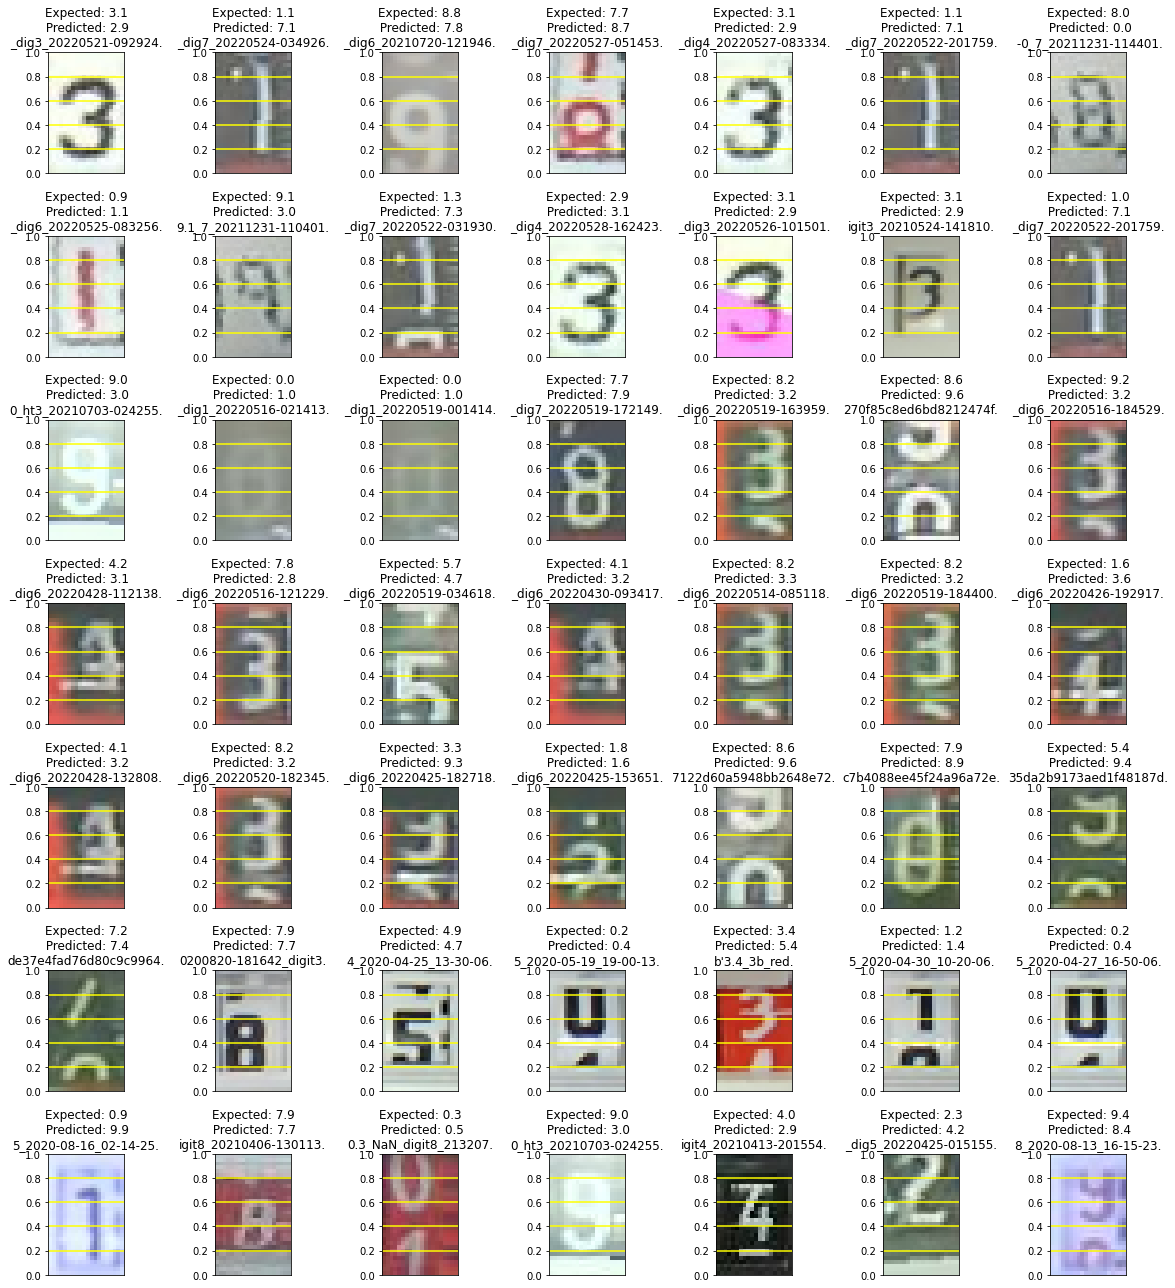

In [6]:
predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data)

### 2nd train

Now the model will be trained like transfer learning <https://keras.io/guides/transfer_learning/>.

All layers except the top layer will be fixed and not trained in the 2nd training.

As dataset the digit meter images are used.

Train data


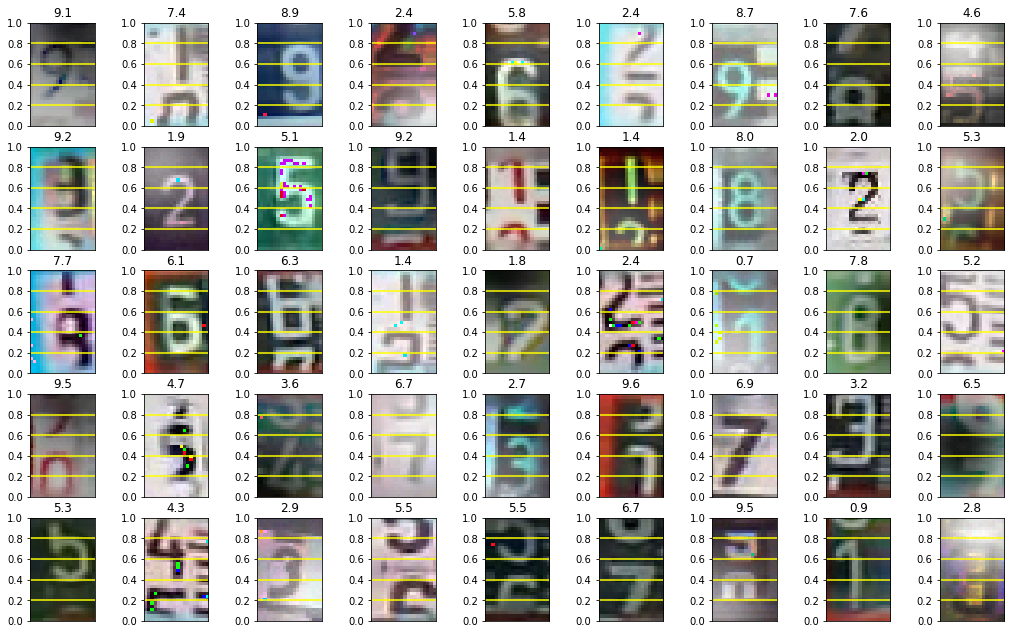

Validation data


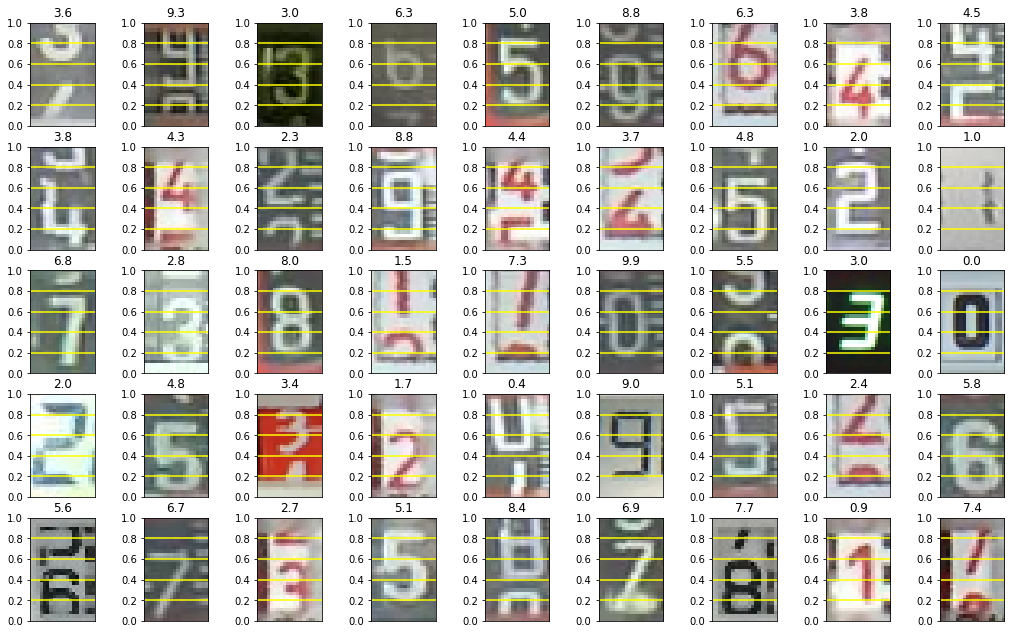

Epoch 1/20


2022-06-13 12:49:40.106892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-13 12:49:44.396080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.82452, saving model to cnn32_best_transfer.h5
312/312 - 5s - loss: 0.6196 - accuracy: 0.8147 - val_loss: 0.6386 - val_accuracy: 0.8245 - lr: 0.0010 - 5s/epoch - 17ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.82452 to 0.82492, saving model to cnn32_best_transfer.h5
312/312 - 5s - loss: 0.5879 - accuracy: 0.8212 - val_loss: 0.6321 - val_accuracy: 0.8249 - lr: 9.8000e-04 - 5s/epoch - 15ms/step
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.82492
312/312 - 5s - loss: 0.6009 - accuracy: 0.8216 - val_loss: 0.6296 - val_accuracy: 0.8225 - lr: 9.6040e-04 - 5s/epoch - 15ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.82492
312/312 - 5s - loss: 0.5746 - accuracy: 0.8257 - val_loss: 0.6286 - val_accuracy: 0.8241 - lr: 9.4119e-04 - 5s/epoch - 15ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.82492
312/312 - 5s - loss: 0.5838 - accuracy: 0.8266 - val_loss: 0.6252 - val_accuracy: 0.8225 - lr: 9.22

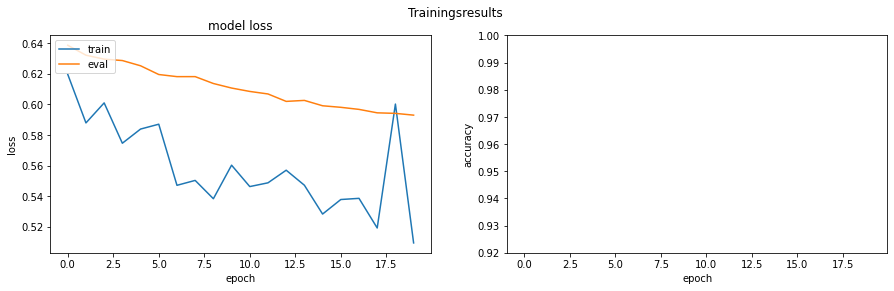

In [7]:
import numpy as np

model = keras.models.load_model(model_filename + '_best.h5')

# now whith meter digits
train_iterator = augmentation(xz_train, yz_train)
validation_iterator = no_augmentation(xz_test, yz_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 

# only the last layer is now trainable
for layer in model.layers[:-1]:
    layer.trainable=False

mc = ModelCheckpoint(model_filename + '_best_transfer.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = 20,
                callbacks=[annealer, earlystop, mc],
                verbose=2)


model.save("model_filename" + "_dist_transfer.h5")

plot_acc_loss(history, "Trainingsresults")


### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation

2022-06-13 12:51:12.343223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Tested images: 12478. 36 false predicted. Accuracy is: 0.9971149222631832


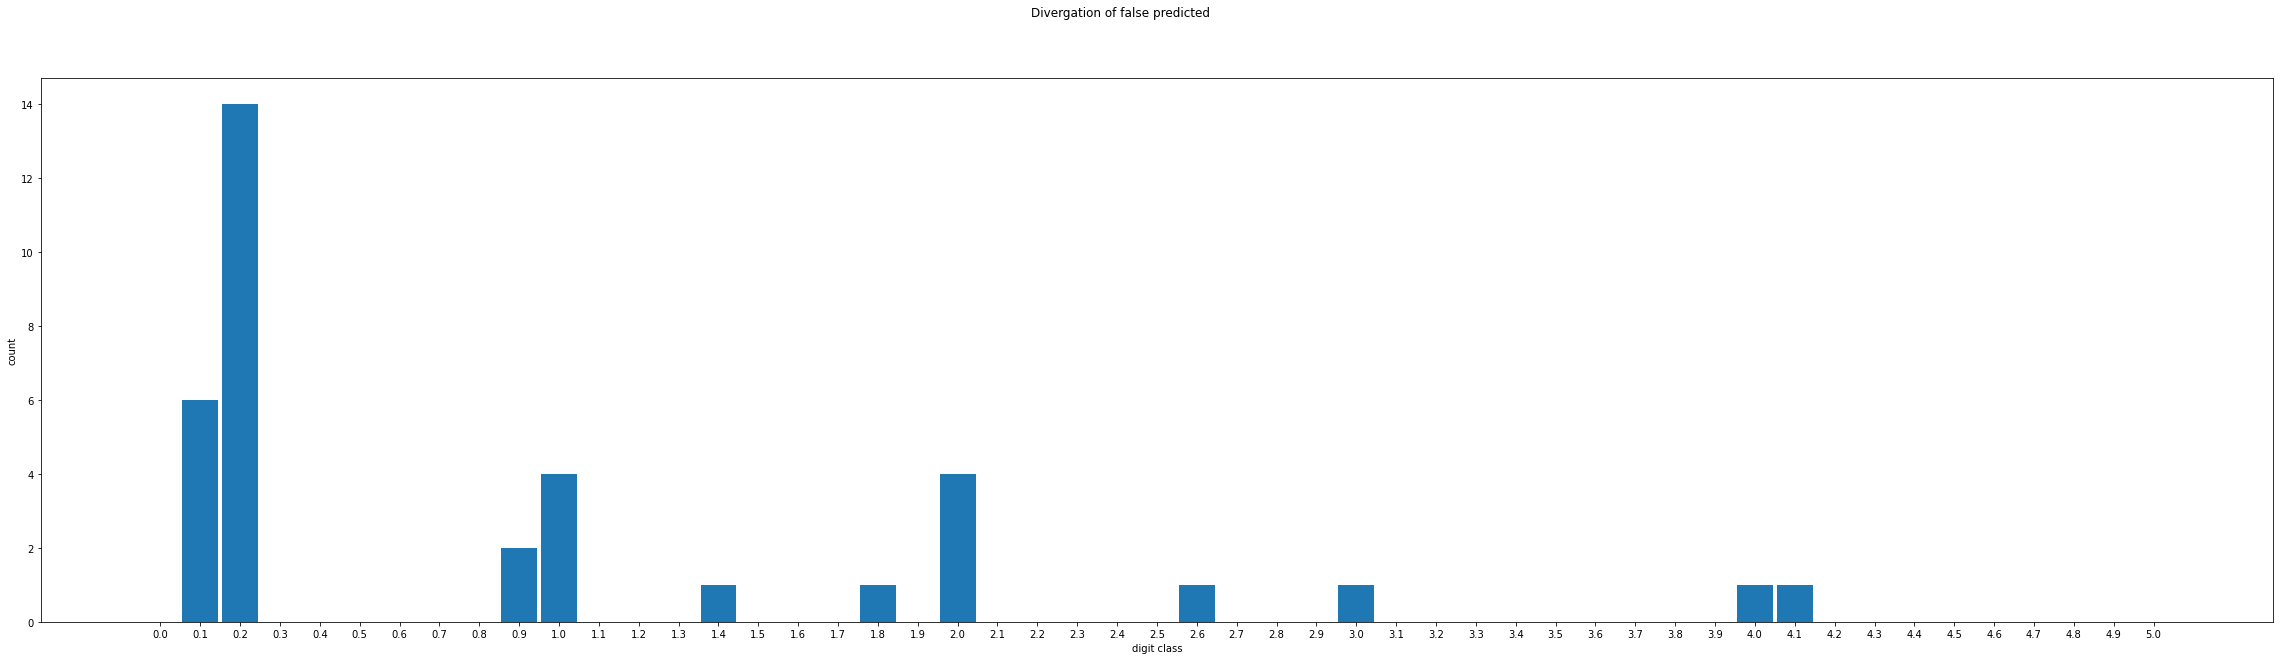

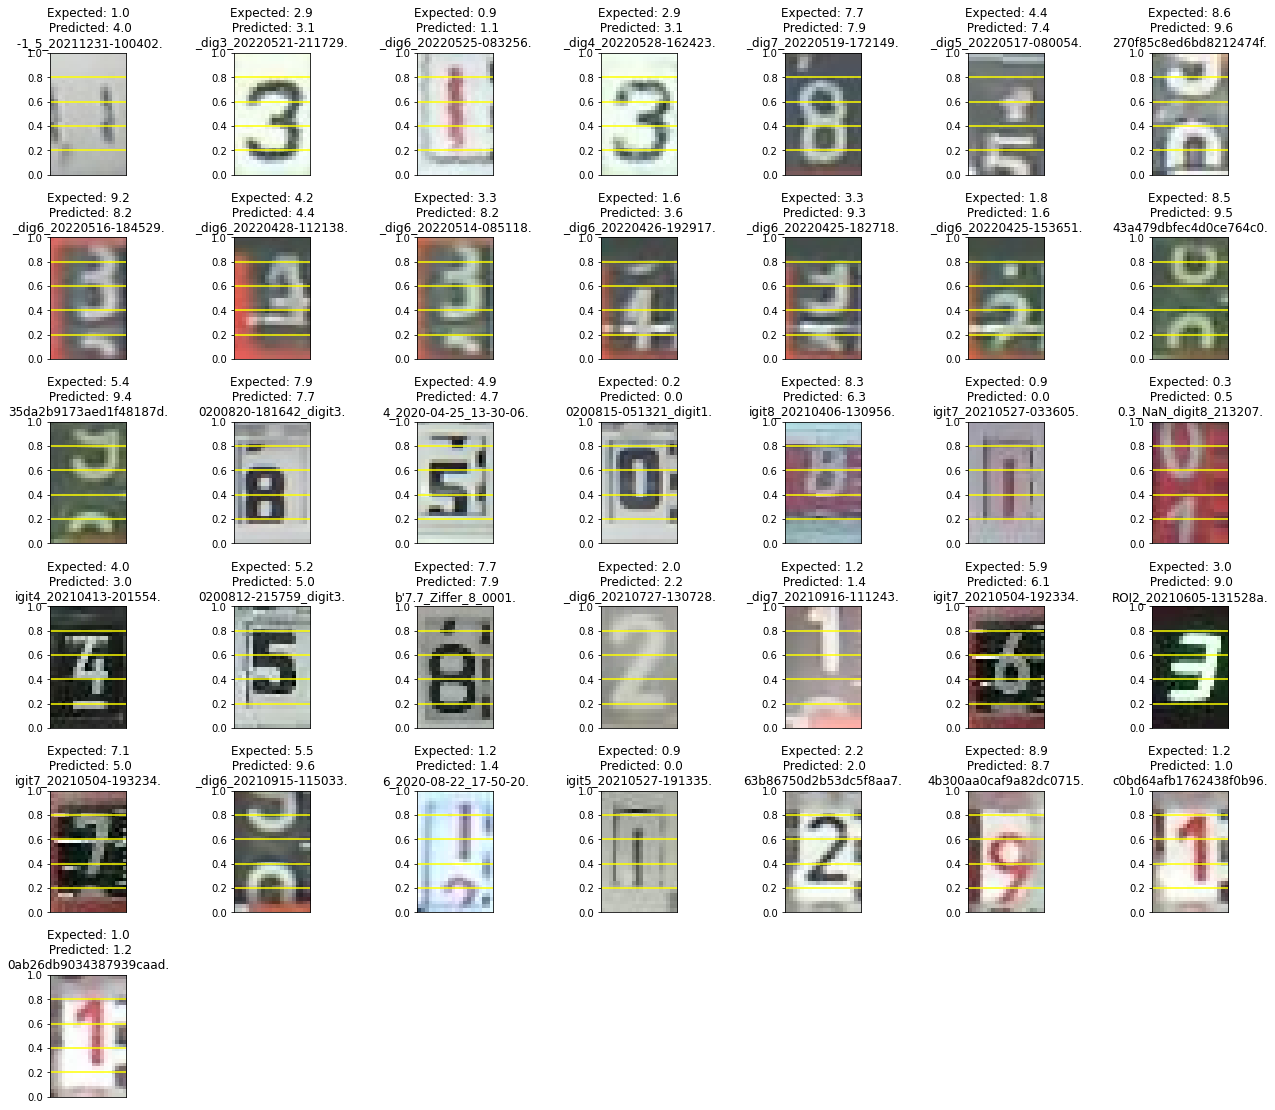

In [8]:
predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data)